In [20]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

## Channels to parse

In [36]:
channels = ['ERSyto', 'ERSytoBleed', 'Hoechst', 'Mito', 'Ph_golgi']
base_dir = '../raw_data/plate_24277/'

def getting_image_paths(channel):
    channel_dir = os.path.join(base_dir, f'{channel}/24277-{channel}')
    image_files = [os.path.join(channel_dir, f) for f in os.listdir(channel_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
    return image_files


In [37]:
def stitch_images_to_grid(image_paths, grid_shape=(3, 2)):
    # Assuming all images have the same dimensions
    sample_img = Image.open(image_paths[0])
    img_width, img_height = sample_img.size
    
    # Determine the grid's total size
    grid_width = img_width * grid_shape[1]
    grid_height = img_height * grid_shape[0]
    
    # Create an empty array for the grid
    grid_array = np.zeros((grid_height, grid_width), dtype=np.uint16)
    
    # Load and place each image into the grid array
    for index, img_path in enumerate(image_paths):
        row = index // grid_shape[1]
        col = index % grid_shape[1]
        # Load the image and convert to numpy array
        img = Image.open(img_path)
        img_array = np.array(img)
        # Place the image in the correct position
        grid_array[row*img_height:(row+1)*img_height, col*img_width:(col+1)*img_width] = img_array
    
    return grid_array

In [38]:


# Function to parse well information from filename
def parse_well_from_filename(filename):
    parts = filename.split('_')
    well = parts[1]  # Assuming the well identifier is always in this position
    return well

# Assuming 'image_files' contains all image paths

def compose_image(image_files):
    well_to_images = {}
    for image_path in image_files:
        well = parse_well_from_filename(os.path.basename(image_path))
        if well not in well_to_images:
            well_to_images[well] = []
        well_to_images[well].append(image_path)
    # Combine images for each well into a composite image
    composite_images = {well: stitch_images_to_grid(paths) for well, paths in well_to_images.items()}
    return composite_images



# Running the entire stitching per Channel

In [39]:
def composite_images_per_channel(channel):
    img_files = getting_image_paths(channel)
    composed_imgs = compose_image(img_files)
    return composed_imgs

In [41]:
def display_image_per_well(channel, well):
    img_files = getting_image_paths(channel)
    composed_imgs = compose_image(img_files)
    well_img = composed_imgs[well]
    plt.imshow(well_img)
    return well_img

array([[226, 250, 324, ..., 147, 153, 151],
       [224, 248, 308, ..., 158, 151, 155],
       [238, 236, 288, ..., 147, 150, 155],
       ...,
       [153, 144, 144, ..., 157, 157, 154],
       [149, 155, 140, ..., 152, 155, 143],
       [154, 146, 151, ..., 164, 149, 157]], dtype=uint16)

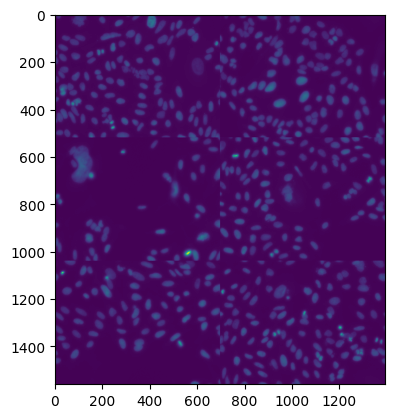

In [42]:
display_image_per_well('Hoechst','a01')